661 Final Project
Group number 1: Ayan Sengupta, Gabe Schulefand, Jake Jackson

1. Importing Libraries and Downloading data sets

In [1]:
# import libraries

%pip install --upgrade numpy==1.25.2
%pip install --upgrade scipy==1.11.2
%pip install requests
import requests
%pip install pandas
import pandas as pd
import numpy as np
%pip install matplotlib
import matplotlib.pyplot as plt
%pip install seaborn
import seaborn as sns
import datetime


  Using cached scipy-1.11.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (59 kB)
Using cached scipy-1.11.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.11.2 which is incompatible.


In [2]:
# import data from air bnb insider into data frames

## San Diego Listings Data (detailed)
san_diego_listings = pd.read_csv('https://data.insideairbnb.com/united-states/ca/san-diego/2024-12-23/data/listings.csv.gz', compression='gzip')
## San Diego Reviews Data (detailed)
san_diego_reviews = pd.read_csv('https://data.insideairbnb.com/united-states/ca/san-diego/2024-12-23/data/reviews.csv.gz', compression='gzip')


2. Exploring the Data and Data Cleaning
   
   link to the data dictionary to understand each column of the listings data: https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=1322284596#gid=1322284596

   link to data dictionary to understand each column of the reviews data: https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=0#gid=0

In [3]:
## exploring the listings data
print(san_diego_listings.info())
print(san_diego_listings.head())
print(san_diego_listings.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12844 entries, 0 to 12843
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            12844 non-null  int64  
 1   listing_url                                   12844 non-null  object 
 2   scrape_id                                     12844 non-null  int64  
 3   last_scraped                                  12844 non-null  object 
 4   source                                        12844 non-null  object 
 5   name                                          12844 non-null  object 
 6   description                                   12638 non-null  object 
 7   neighborhood_overview                         8046 non-null   object 
 8   picture_url                                   12844 non-null  object 
 9   host_id                                       12844 non-null 

So listing has 12844 rows and 75 columns. A lot of these columns contain listing and host urls and images that are not useful for analysis. We will be dropping them. The calculated_* columns have no information about what they are in the dictionary and we will be dropping them as well.

In [4]:
calculated_columns = san_diego_listings.columns[san_diego_listings.columns.str.startswith('calculated_')]

## list of fields to be dropped
columns_to_drop = [
    'listing_url','license', 'scrape_id', 'last_scraped',
    'source', 'picture_url', 'host_url', 'host_name', 'host_thumbnail_url',
    'host_picture_url', 'host_since', 'host_location', 'host_has_profile_pic',
    'host_listings_count', 'host_neighbourhood', 'host_verifications','host_about','description',
    'neighborhood_overview', 'calendar_last_scraped','first_review','last_review', 'minimum_nights_avg_ntm','minimum_minimum_nights',
    'maximum_minimum_nights', 'maximum_maximum_nights', 'minimum_maximum_nights', 'maximum_nights_avg_ntm',
    'reviews_per_month'
]
## get all the fields that start with calculated_ and add them to the columns_to_drop list
for i in calculated_columns:
    columns_to_drop.append(i)

## dropping columns that are not needed
san_diego_listings_cleaned = san_diego_listings.drop(columns=columns_to_drop)


we will now look at missing values and distributions for the remaining columns to analyze it further.

In [5]:
## looking at how many null values are in the data
print(san_diego_listings_cleaned.isnull().sum())

## looking at the data types for each column
print(san_diego_listings_cleaned.dtypes)


id                                  0
name                                0
host_id                             0
host_response_time               1461
host_response_rate               1461
host_acceptance_rate              941
host_is_superhost                 423
host_total_listings_count           0
host_identity_verified              0
neighbourhood                    4798
neighbourhood_cleansed              0
neighbourhood_group_cleansed    12844
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1184
bathrooms_text                      1
bedrooms                          204
beds                             1224
amenities                           0
price                            1184
minimum_nights                      0
maximum_nights                      0
calendar_updated                12844
has_availabi

neighbourhood_group_cleansed and calender_updated columns have only null values and nothing else and can hence be removed. further neighbourhoood_clensed is a more accurate version of neighbourhood hence the column neighborhood is removed. some of the other columns have a few null values but we will deal with those in a future step by either imputing those values.

In [6]:
san_diego_listings_cleaned = san_diego_listings_cleaned.drop(columns=['neighbourhood_group_cleansed','calendar_updated','neighbourhood'])

Some columns in the data frame are of the wrong type. host reponse time is an object (text) and will not be used (hence dropeed),host response rate and acceptance rates will have to converted to integrs, host identity verified will have to converted to boolean (1 for true, 0 for false). We do not look at property type as it is supplied by the lister and we are not dividing listings by property type. we will need to further analyze room_type and likely convert it into a dummy variable. bathroom_text provides no useful information when compared to bathrooms and hence is removed completly. price is of type object likely due to the '$' we will fix this. has availability will need to be converted to a binary instead of text. Finally instant_bookable will also have to converted to a binary column.

In [7]:
san_diego_listings_cleaned = san_diego_listings_cleaned.drop(columns=['host_response_time','property_type','bathrooms_text'])

In [8]:


## convert the host_response_rate and host_acceptance_rate columns to numeric
san_diego_listings_cleaned['host_response_rate'] = san_diego_listings_cleaned['host_response_rate'].str.replace('%','').astype(float)
san_diego_listings_cleaned['host_acceptance_rate'] = san_diego_listings_cleaned['host_acceptance_rate'].str.replace('%','').astype(float)

# convert host_identity_verified to a binary value
san_diego_listings_cleaned['host_identity_verified'] = san_diego_listings_cleaned['host_identity_verified'].replace({'t': 1, 'f': 0}).astype(int)

## convert price to a numeric value
san_diego_listings_cleaned['price'] = san_diego_listings_cleaned['price'].str.replace('$','').str.replace(',','').astype(float)

## has availibity contains some inf values - we will replace them with -1s
san_diego_listings_cleaned['has_availability'] = san_diego_listings_cleaned['has_availability'].replace({np.nan: -1 , np.inf: -1})
san_diego_listings_cleaned['has_availability'] = san_diego_listings_cleaned['has_availability'].replace({'t': 1, 'f': 0}).astype(int)

## conver instant_bookable to a binary value
san_diego_listings_cleaned['instant_bookable'] = san_diego_listings_cleaned['instant_bookable'].replace({'t': 1, 'f': 0}).astype(int)

## convert host_is_superhost to a binary value
san_diego_listings_cleaned['host_is_superhost'] = san_diego_listings_cleaned['host_is_superhost'].replace({np.nan: -1 , np.inf: -1})
san_diego_listings_cleaned['host_is_superhost'] = san_diego_listings_cleaned['host_is_superhost'].replace({'t': 1, 'f': 0}).astype(int)

## convert room_type to a dummy variables then rename them
san_diego_listings_cleaned = pd.get_dummies(san_diego_listings_cleaned, columns=['room_type'], prefix='room_type')
san_diego_listings_cleaned = san_diego_listings_cleaned.rename(columns={'room_type_Entire home/apt': 'room_type_entire_home', 'room_type_Private room': 'room_type_private_room', 'room_type_Shared room': 'room_type_shared_room','room_type_Hotel room':'room_type_hotel_room'})




<ipython-input-8-4189f81c4bd8>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  san_diego_listings_cleaned['host_identity_verified'] = san_diego_listings_cleaned['host_identity_verified'].replace({'t': 1, 'f': 0}).astype(int)
<ipython-input-8-4189f81c4bd8>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  san_diego_listings_cleaned['has_availability'] = san_diego_listings_cleaned['has_availability'].replace({'t': 1, 'f': 0}).astype(int)
<ipython-input-8-4189f81c4bd8>:16: FutureWarning: Downcasting behavior in `replace` is deprecat

Now with our primary cleaning done on the listings data set, lets look at missing values again

In [9]:
## look at missing values
print(san_diego_listings_cleaned.isnull().sum())




id                                0
name                              0
host_id                           0
host_response_rate             1461
host_acceptance_rate            941
host_is_superhost                 0
host_total_listings_count         0
host_identity_verified            0
neighbourhood_cleansed            0
latitude                          0
longitude                         0
accommodates                      0
bathrooms                      1184
bedrooms                        204
beds                           1224
amenities                         0
price                          1184
minimum_nights                    0
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
number_of_reviews_ltm             0
number_of_reviews_l30d            0
review_scores_rating        

We will be imputing the missing values starting the host response rate and hoset acceptance rates. There are a few ways to do this - we are going to group the listing by what neighborhood they are in, then take a median of each groups response rate and acceptance rate and use that to fill the missing values.

In [10]:
## group by neighbourhood_clensed, then impute missing values with the median value per group
san_diego_listings_cleaned['host_response_rate'] = san_diego_listings_cleaned.groupby('neighbourhood_cleansed')['host_response_rate'].transform(lambda x: x.fillna(x.median()))
san_diego_listings_cleaned['host_acceptance_rate'] = san_diego_listings_cleaned.groupby('neighbourhood_cleansed')['host_acceptance_rate'].transform(lambda x: x.fillna(x.median()))

## look at these two columns again to make sure we got all the missing values
print(san_diego_listings_cleaned['host_acceptance_rate'].isnull().sum())
print(san_diego_listings_cleaned['host_response_rate'].isnull().sum())



0
0


next we will impute the missing values in batrooms, bedrooms and beds. We will use a similar approach to before but we will group by accomodates since that is usually a good indicator of how many rooms are in the property and then take a median of each group to fill the missing values.

In [11]:
columns_to_impute = ['bathrooms','bedrooms','beds']
for col in columns_to_impute:
    san_diego_listings_cleaned[col]=san_diego_listings_cleaned.groupby('accommodates')[col] \
        .transform(lambda x: x.fillna(x.median()))
    print(f"missing values in {col}:{san_diego_listings_cleaned[col].isnull().sum()}")




missing values in bathrooms:0
missing values in bedrooms:0
missing values in beds:0


Next we will impute the missing prices of the listings - the most logical way is to group the listings by neighbourhood since listing prices are usually tied to the neighnourhood and then fill the missing values with the median price of the group they belong to.

In [12]:
san_diego_listings_cleaned['price'] = san_diego_listings_cleaned.groupby('neighbourhood_cleansed')['price'].transform(lambda x: x.fillna(x.median()))
print(san_diego_listings_cleaned['price'].isnull().sum())

0


The last imputations left to do are review_scores_ratings, review_scores_accuracy,review_scores_cleanliness, review_scores_checkin, communication, location and value. sine we do not care of listings with no reviews for this project we drop the records with the missing values.

In [13]:
## remove the missing values
san_diego_listings_cleaned = san_diego_listings_cleaned.dropna(subset=['review_scores_rating'])

## look at missing value tallies
print(san_diego_listings_cleaned.isnull().sum())


id                             0
name                           0
host_id                        0
host_response_rate             0
host_acceptance_rate           0
host_is_superhost              0
host_total_listings_count      0
host_identity_verified         0
neighbourhood_cleansed         0
latitude                       0
longitude                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
amenities                      0
price                          0
minimum_nights                 0
maximum_nights                 0
has_availability               0
availability_30                0
availability_60                0
availability_90                0
availability_365               0
number_of_reviews              0
number_of_reviews_ltm          0
number_of_reviews_l30d         0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_sco

Lets plot a correlatin matrix with the remaining numerical features to see which ones are tighty correlated. We will drop features that are super tighly correlated since they will not add any value to our analysis.

<class 'pandas.core.frame.DataFrame'>
Index: 10638 entries, 0 to 12807
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           10638 non-null  int64  
 1   name                         10638 non-null  object 
 2   host_id                      10638 non-null  int64  
 3   host_response_rate           10638 non-null  float64
 4   host_acceptance_rate         10638 non-null  float64
 5   host_is_superhost            10638 non-null  int64  
 6   host_total_listings_count    10638 non-null  int64  
 7   host_identity_verified       10638 non-null  int64  
 8   neighbourhood_cleansed       10638 non-null  object 
 9   latitude                     10638 non-null  float64
 10  longitude                    10638 non-null  float64
 11  accommodates                 10638 non-null  int64  
 12  bathrooms                    10638 non-null  float64
 13  bedrooms             

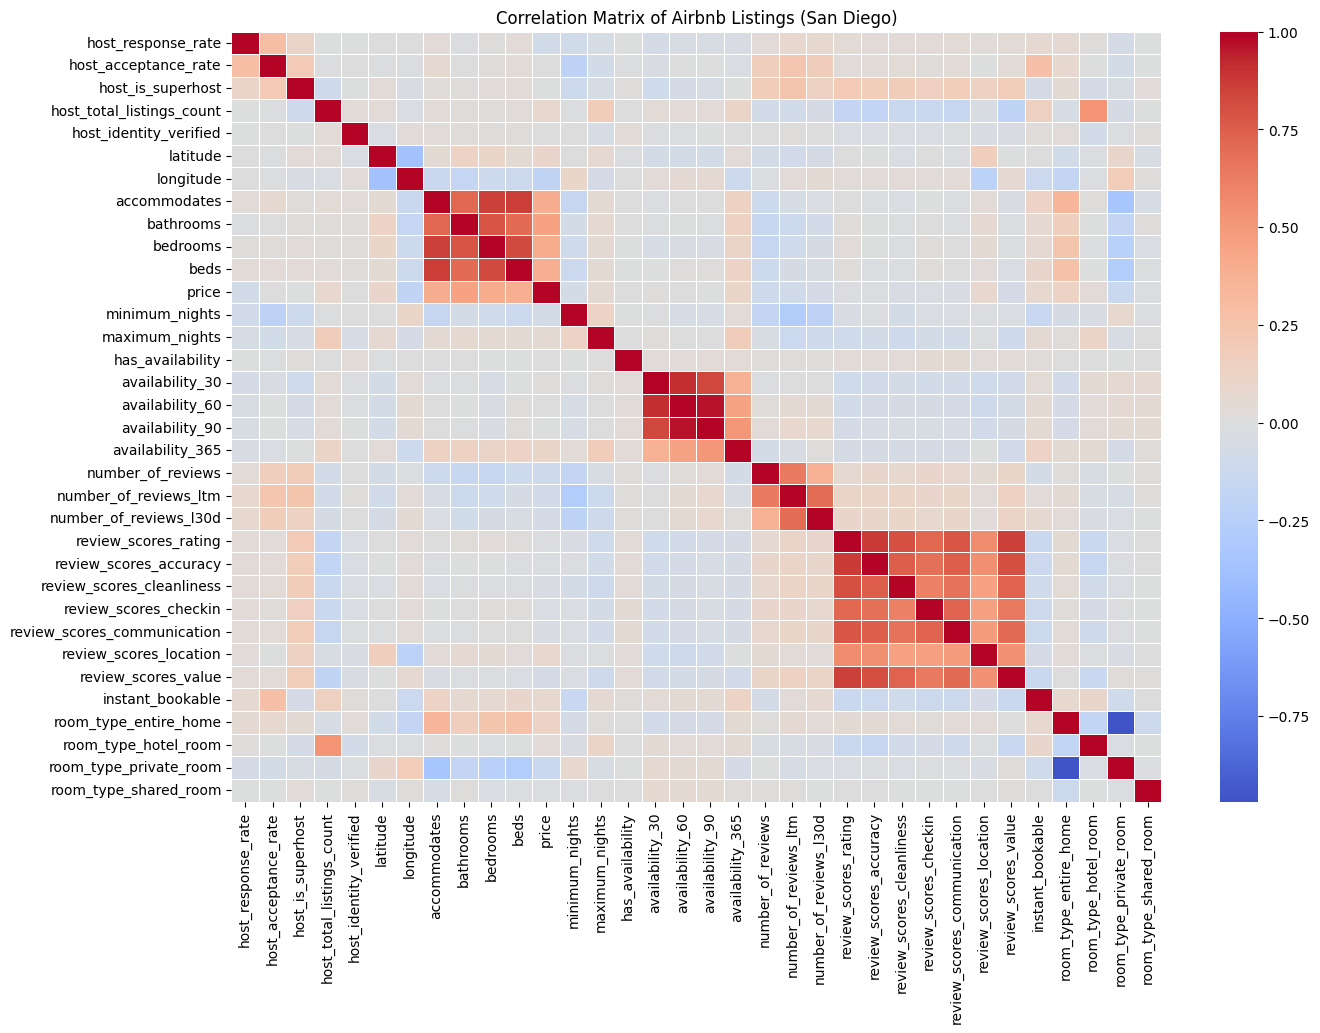

In [14]:
## following columns are either non numeric or unique identifier, we will exclude them for the correlation matrix
print(san_diego_listings_cleaned.info())
cols_to_exc = ['id','neighbourhood_cleansed','amenities','name','host_id']
cor_matrix_df = san_diego_listings_cleaned.drop(columns= cols_to_exc)
# Compute correlation matrix
corr_matrix = cor_matrix_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)

# Title
plt.title("Correlation Matrix of Airbnb Listings (San Diego)")
plt.show()

a) availability columns are tightly correlated. Dropping all of them except the availability_365.

b) accommodates, bathrooms, bedrooms, beds are all strongly positively correlated. All of these in some way measure capacity so this is not unusual. Since we will not be
running any kind of prediction based on these, we will drop the beds column (bedrooms provide sufficient info in this case) and keep the rest.

c) number_of_reviews, number_of_reviews_ltm (last 12 months), number_of_reviews_l30d (last 30 days) are all strongly positively correlated. They all
measure review volume, just over different time frames. Since we are only going to be looking at recent reviews, we will keep number_of_reviews_ltm.


In [15]:
## setting columns to drop
correlated_colums = ['availability_30','availability_60','availability_90','beds','number_of_reviews','number_of_reviews_l30d']
san_diego_listings_cleaned = san_diego_listings_cleaned.drop(columns=correlated_colums)

Now that we have removed super tightly coupled coulums lets look at the statistics of the numeriacal columns in the listings data.

In [16]:
print(san_diego_listings_cleaned.describe())
print(san_diego_listings_cleaned['price'].describe())

                 id       host_id  host_response_rate  host_acceptance_rate  \
count  1.063800e+04  1.063800e+04        10638.000000          10638.000000   
mean   4.774175e+17  1.667961e+08           98.453939             91.996334   
std    4.888592e+17  1.790876e+08            8.549459             17.929967   
min    6.000000e+00  2.900000e+01            0.000000              0.000000   
25%    3.279893e+07  2.395070e+07          100.000000             95.000000   
50%    5.733670e+17  8.291917e+07          100.000000             99.000000   
75%    9.349477e+17  2.974525e+08          100.000000            100.000000   
max    1.315611e+18  6.647825e+08          100.000000            100.000000   

       host_is_superhost  host_total_listings_count  host_identity_verified  \
count       10638.000000               10638.000000            10638.000000   
mean            0.517390                  77.838785                0.895187   
std             0.564391                 421.676277

1)	The host_response_rate has a mean of about 98.45 and a median of 100, suggesting that most hosts reply promptly.

2)	Similarly, the host_acceptance_rate is very high (mean ~92, median 99), indicating that once contacted, most hosts tend to accept booking requests.

3)	The host_total_listings_count is highly skewed (median of 6 vs. a mean of nearly 78) with some hosts managing a very large number of listings, indicating the presence of both individual hosts and larger property management companies

4)	The average listing accommodates about 5 guests (mean 5.1, range from 1 to 16). This suggests a mix of small and larger properties, possibly catering to families or groups.

5)	availability_365 has a mean of about 205 days, with a median of 220 days. This indicates that many listings are not available year-round—possibly due to seasonal use or host preferences.

6) The price ranges from 26$ a night to 11998$ a night with a mean of 308$ a night. This is consistent with usual pricing of a 2 bed hotel in san deigo for a night.


**Distribution and spread Analysis on analytically important numerical columns**

histogram for the follwing columns: Price, Accommodates, Host Total Listings to check for skewness, outliers etc.


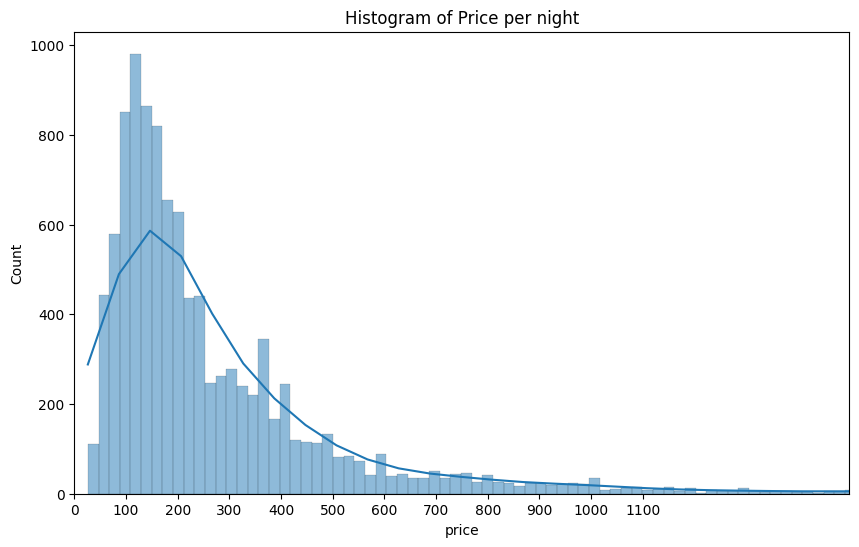

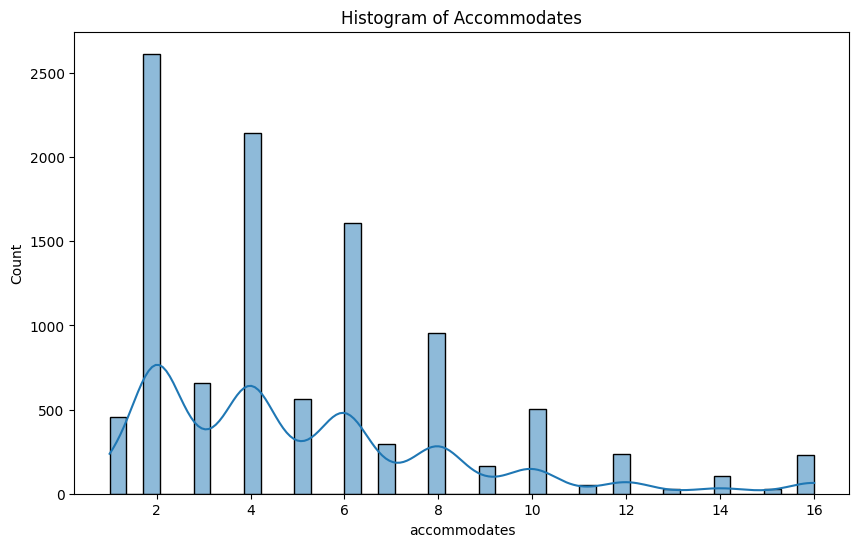

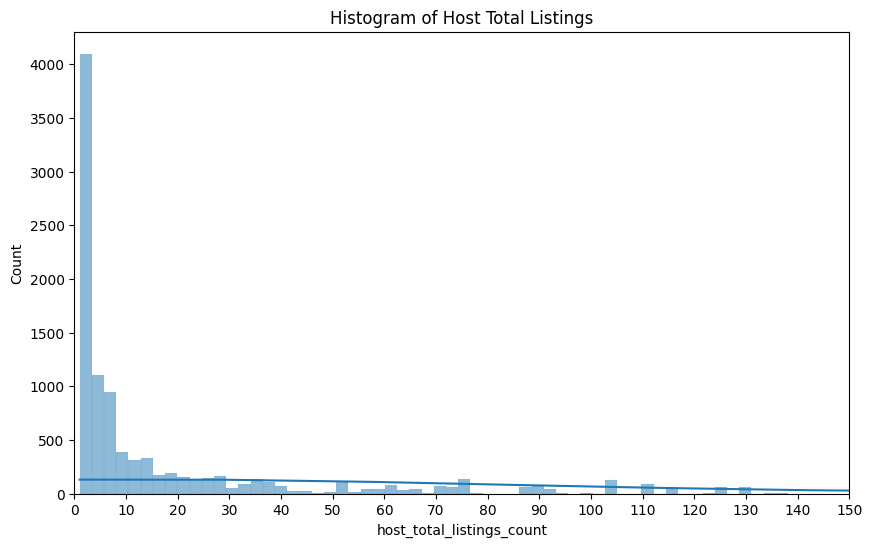

In [17]:
## histogram for price
plt.figure(figsize=(10,6))
sns.histplot(san_diego_listings_cleaned['price'], kde=True)
plt.xticks(np.arange(0, 1200, 100))  # Set x-axis ticks
plt.xlim(0, 1500)  # Set x-axis limits
plt.title('Histogram of Price per night')
plt.show()

## histogram for accommodates
plt.figure(figsize=(10,6))
sns.histplot(san_diego_listings_cleaned['accommodates'], kde=True)
plt.title('Histogram of Accommodates')
plt.show()

## plot the host_total_listings_count, adjusting scale from 1 to 150 for the count
plt.figure(figsize=(10,6))
sns.histplot(san_diego_listings_cleaned['host_total_listings_count'], kde=True)
plt.xticks(np.arange(0, 151, 10))  # Set x-axis ticks
plt.xlim(0, 150)  # Set x-axis limits
plt.title('Histogram of Host Total Listings')
plt.show()



Price: Most listings cluster at lower price ranges (roughly under $200), and then the tail extends toward higher prices, indicating a handful of more expensive properties (right skewed distribution). Theres a visible peak somewhere around $100 to $150 per night, suggesting that many listings fall into that affordable to mid-range price category. There are clearly outliers here (in the far-right end, really high prices, likely luxury stays) but since we are not really using this to predict anything we will not delete any.

Accommodates: The highest bar is for listings that accommodate 2 guests, followed by 4 guests. This suggests that most of San Diego Airbnb listings cater to couples or small families/groups. As the number of guests increases (6, 8, 10, 12, 14, 16), the count of listings steadily drops. Large-group listings exist but are much less common.

Host_total_listings_count: The vast majority of hosts have relatively few listings (likely in the range of 1–5), and then the distribution extends out to higher numbers with very few hosts managing many listings. This is inline with what we hypothesized earlier – there are likely some management companies with 100s of properties listed under them.


**Visualizing Analytically important categorical variables**

We will create a bar charts for the following columns: neighbourhood_clensed

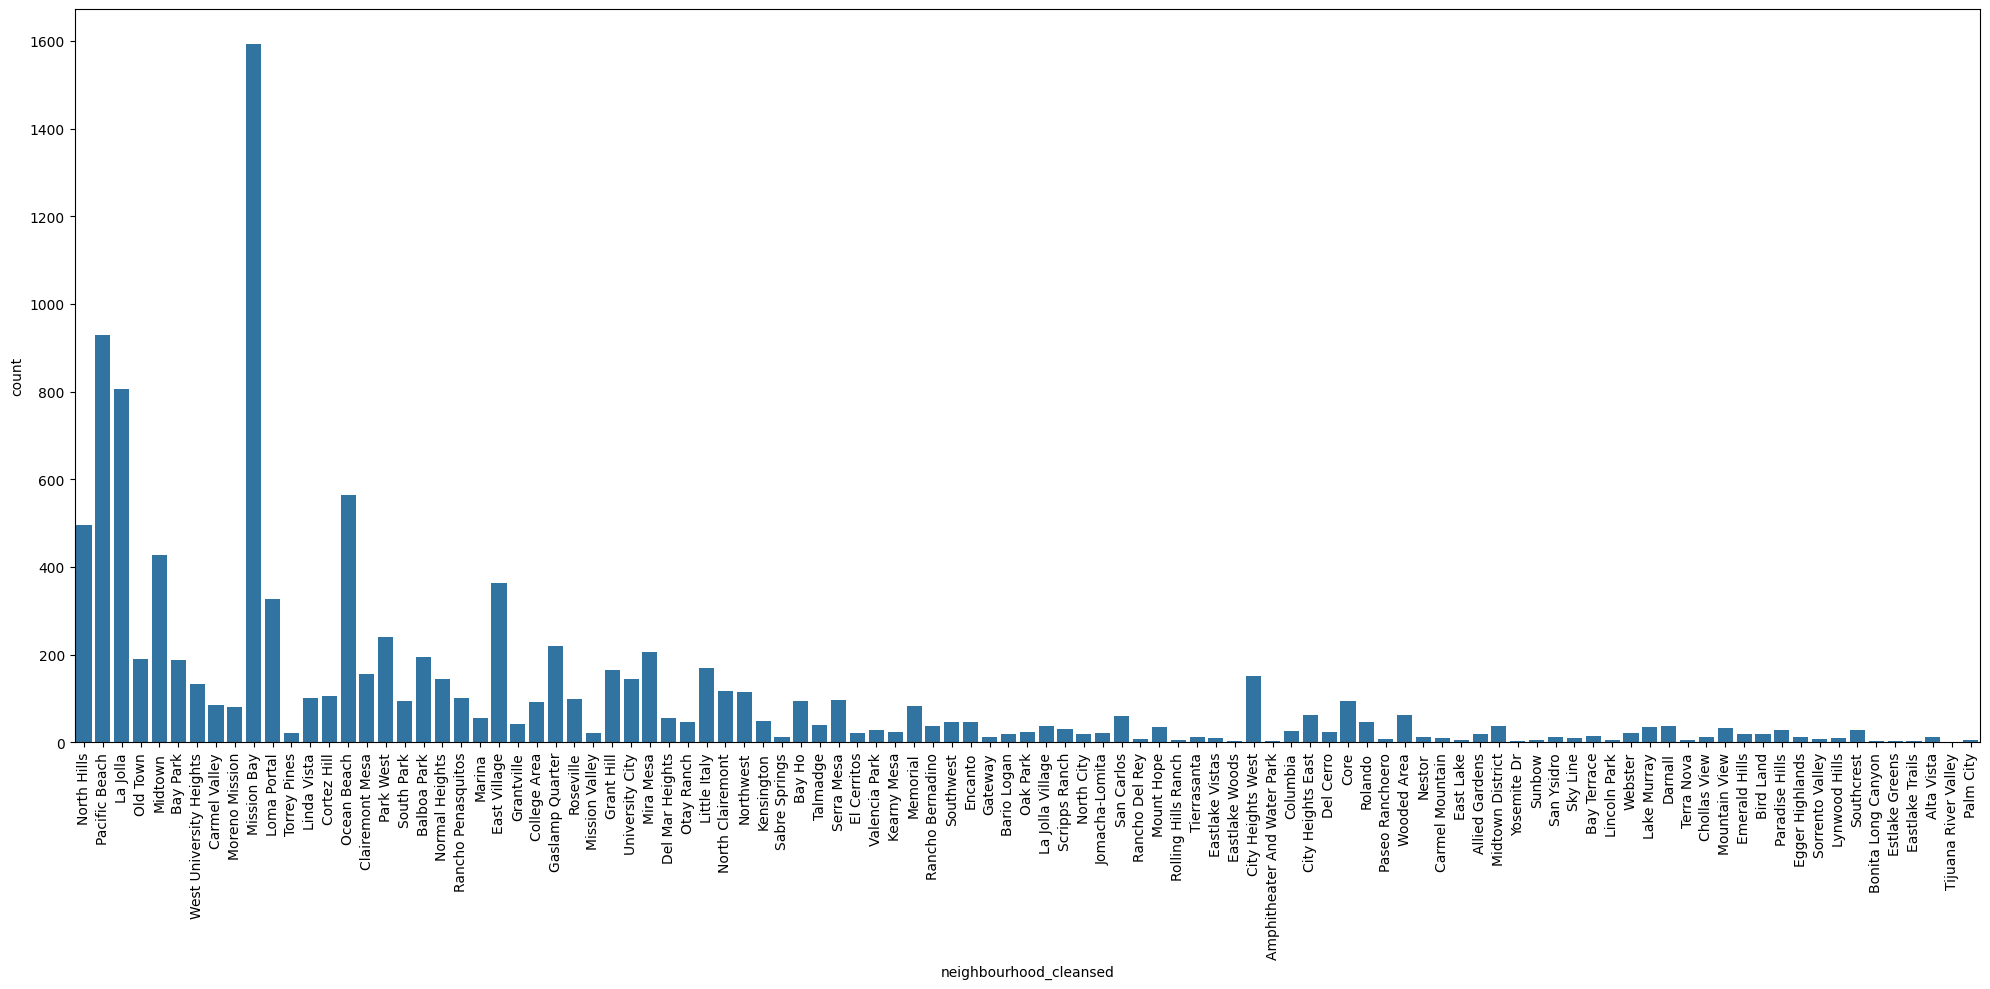

In [18]:
## columns to create bar chart plots for
categorical_cols = ['neighbourhood_cleansed']
## create plot
for col in categorical_cols:
    plt.figure(figsize=(20,10))
    sns.countplot(data=san_diego_listings_cleaned, x=col)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()



In [19]:
# check size of listings data after all the cleaning
print(san_diego_listings_cleaned.shape)

(10638, 33)


Certain neighborhoods stand out as hotspots for Airbnb listings, such as Pacific Beach, Mission Bay and North Hills. These areas likely attract more tourists and may be favored due to their proximity to beaches, attractions, or lively environments.

We could further look at bivariate relationship’s b/w some of the columns like price and neighborhood but since our main intention is to look at the sentiments and then look at what features might be contributing to them, bivariate analysis at this point is not required.

Next we will look at the reviews data

In [20]:
## exploring the reviews data
print(san_diego_reviews.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839296 entries, 0 to 839295
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     839296 non-null  int64 
 1   id             839296 non-null  int64 
 2   date           839296 non-null  object
 3   reviewer_id    839296 non-null  int64 
 4   reviewer_name  839294 non-null  object
 5   comments       839097 non-null  object
dtypes: int64(3), object(3)
memory usage: 38.4+ MB
None


We do not need id,reviewer_id,reviewer_name so we drop them

In [21]:
## drop the columns we do not need
san_diego_reviews_cleaned = san_diego_reviews.drop(columns=['id','reviewer_id','reviewer_name'])
print(san_diego_reviews_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839296 entries, 0 to 839295
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   listing_id  839296 non-null  int64 
 1   date        839296 non-null  object
 2   comments    839097 non-null  object
dtypes: int64(1), object(2)
memory usage: 19.2+ MB
None


date is of type object - we will convert it to date type

In [22]:
## convert date column to type date
san_diego_reviews_cleaned['date'] = pd.to_datetime(san_diego_reviews_cleaned['date'])
print(san_diego_reviews_cleaned.head())

   listing_id       date                                           comments
0       29967 2010-07-09  When I booked our stay in San Diego at Dennis ...
1       29967 2010-07-14  This was my first experience with using airbnb...
2       29967 2010-07-22  We found the house to be very accommodating--e...
3       29967 2010-07-29  As advertised and more. Dennis was very helpfu...
4       29967 2010-08-07  We had a great time in San Diego. Denis' house...


In [23]:
%pip install langdetect
%pip install tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=6ed37284e6dd70c544d68426bff85b60c9de445bd6e53780f3646d417acee64b
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


  We only want english comments and the 5 most recent english comments at that - so we detect the language and drop non english columns - this is beacause we are using Vader Sentiment Analysis and it only works on english text

We will use langdetect to detect the language of the reviews and then drop the non english reviews.

In [24]:

from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from langdetect import detect

def detect_language(text):
  try:
    return detect(text)
  except:
    return 'unknown'

with ProcessPoolExecutor() as executor:
  results = list(tqdm(executor.map(detect_language, san_diego_reviews_cleaned['comments']), total=len(san_diego_reviews_cleaned)))

san_diego_reviews_cleaned['language'] = results

100%|██████████| 839296/839296 [34:23<00:00, 406.78it/s]


Checking how many reviews are in english, we find that ~ 90 %of the reviews are in english so we can safely drop the non-english reviews.

In [25]:
print(san_diego_reviews_cleaned['language'].value_counts())

language
en         807261
es           7794
fr           3711
de           3694
ro           2974
unknown      1785
zh-cn        1681
af           1136
ko           1122
it            936
so            934
pt            931
tl            737
ca            564
nl            482
cs            386
pl            356
ja            283
no            269
sw            247
da            216
sv            211
hu            166
ru            165
hr            152
id            147
cy            141
zh-tw         134
vi            114
tr            113
sl            105
fi             77
et             75
he             56
ar             48
sk             42
sq             16
lt             11
lv              8
uk              5
th              3
bg              3
el              2
mk              2
fa              1
Name: count, dtype: int64


In [26]:
orinal_size = san_diego_reviews_cleaned.shape[0]
print(orinal_size)
# keep only english comments
san_diego_reviews_cleaned = san_diego_reviews_cleaned[san_diego_reviews_cleaned['language'] == 'en']
neww_size = san_diego_reviews_cleaned.shape[0]
print(f"dropeed {orinal_size - neww_size} rows")


839296
dropeed 32035 rows


In [27]:

# Sort by listing_id and date
san_diego_reviews_cleaned = san_diego_reviews_cleaned.sort_values(['listing_id', 'date'], ascending=[True, False])

# Group by listing_id and get the top 5 latest comments
san_diego_reviews_cleaned = san_diego_reviews_cleaned.groupby('listing_id').head(5)

# Reset index if needed
san_diego_reviews_cleaned = san_diego_reviews_cleaned.reset_index(drop=True)

## no of rows atfer clean up
print(san_diego_reviews_cleaned.shape)


(47707, 4)


In [28]:
# looking at what the data set looks like
print(san_diego_reviews_cleaned.head(100))

    listing_id       date                                           comments  \
0            6 2024-10-20  Loved our stay! We were there for a wedding in...   
1            6 2024-10-13  Absolutely loved this stay!  Right in the midd...   
2            6 2024-08-18  Sara's place is centrally located in North Par...   
3            6 2024-08-16  the home was great, it had a very comfy feel t...   
4            6 2024-08-15  Had an amazing stay at Sarah’s place! She is a...   
..         ...        ...                                                ...   
95      182428 2023-07-25  awesome place, close enough to the water. only...   
96      182428 2023-06-16  Fabulous location. Central to either the beach...   
97      182428 2023-06-04                      Nice place…close to the beach   
98      182428 2022-10-03  We very much enjoyed our stay at Luke's place,...   
99      182504 2024-10-22  I cannot say enough about how much I enjoyed m...   

   language  
0        en  
1        en

In [29]:
# check how many reviews eacg listing has
print(san_diego_reviews_cleaned['listing_id'].value_counts())


listing_id
6                      5
698456755728387698     5
696503088612245611     5
696888486410529102     5
697093351576120156     5
                      ..
1206779053528941798    1
1206888753587489205    1
1207273264069446756    1
927536645524952680     1
888660388439214901     1
Name: count, Length: 10591, dtype: int64


Some listings do not hace 5 english (or in some cases just do not have 5) reviews which is expected so we will aggreated based on reviews available

we will be using VADER for our sentiment analysis - lets import the required libraries



In [30]:
%pip install vaderSentiment==3.3.2
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.4 MB/s eta 0:00:00


 We will use VADER to get the sentiment scores for each review and then take the mean of the 5 latest reviews for each listing. We will then merge this with the listings data set on listing_id.

In [31]:
print(san_diego_reviews_cleaned['language'].value_counts())

language
en    47707
Name: count, dtype: int64


In [32]:
# Filter out rows where 'comments' is missing or empty
san_diego_reviews_cleaned_nonull = san_diego_reviews_cleaned[san_diego_reviews_cleaned['comments'].notnull()]
dropped_rows = san_diego_reviews_cleaned.shape[0] - san_diego_reviews_cleaned_nonull.shape[0]
print(f"Dropped {dropped_rows} rows with missing or empty comments.")

# Reapply sentiment analysis to the filtered dataset
analyzer = SentimentIntensityAnalyzer()
san_diego_reviews_cleaned_nonull['sentiment'] = san_diego_reviews_cleaned_nonull['comments'].apply(lambda review: analyzer.polarity_scores(review)['compound'])

# Check the updated dataset
print(san_diego_reviews_cleaned_nonull.head())

Dropped 0 rows with missing or empty comments.
   listing_id       date                                           comments  \
0           6 2024-10-20  Loved our stay! We were there for a wedding in...   
1           6 2024-10-13  Absolutely loved this stay!  Right in the midd...   
2           6 2024-08-18  Sara's place is centrally located in North Par...   
3           6 2024-08-16  the home was great, it had a very comfy feel t...   
4           6 2024-08-15  Had an amazing stay at Sarah’s place! She is a...   

  language  sentiment  
0       en     0.9600  
1       en     0.9536  
2       en     0.9550  
3       en     0.8122  
4       en     0.9622  


we now have the sentimenet scores (ranging from 0 to 1) for each comment - we will now aggrete this by listing ID to get an idea of average sentiment for the listing.

We will now scaled it to be between 1 to 5 for better readability uaing k means discretizer


In [33]:
san_diego_reviews_cleaned_nonull.head()


,listing_id,date,comments,language,sentiment
0,6,2024-10-20,Loved our stay! We were there for a wedding in...,en,0.9600
1,6,2024-10-13,Absolutely loved this stay! Right in the midd...,en,0.9536
2,6,2024-08-18,Sara's place is centrally located in North Par...,en,0.9550
3,6,2024-08-16,"the home was great, it had a very comfy feel t...",en,0.8122
4,6,2024-08-15,Had an amazing stay at Sarah’s place! She is a...,en,0.9622


In [34]:
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer


In [35]:
# Initialize the discretizer
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
kbd.fit(san_diego_reviews_cleaned_nonull[['sentiment']])

reviews_binned = kbd.transform(san_diego_reviews_cleaned_nonull[['sentiment']]) +1
san_diego_reviews_cleaned_nonull['sentiment_scaled'] = reviews_binned

# display the results
print(san_diego_reviews_cleaned_nonull.head())

   listing_id       date                                           comments  \
0           6 2024-10-20  Loved our stay! We were there for a wedding in...   
1           6 2024-10-13  Absolutely loved this stay!  Right in the midd...   
2           6 2024-08-18  Sara's place is centrally located in North Par...   
3           6 2024-08-16  the home was great, it had a very comfy feel t...   
4           6 2024-08-15  Had an amazing stay at Sarah’s place! She is a...   

  language  sentiment  sentiment_scaled  
0       en     0.9600               5.0  
1       en     0.9536               5.0  
2       en     0.9550               5.0  
3       en     0.8122               5.0  
4       en     0.9622               5.0  


we will now aggreate these scaled_scores by listing id so that there is only 1 record per listing id

In [36]:
# drop sentiment and language cols
san_diego_reviews_cleaned_nonull = san_diego_reviews_cleaned_nonull.drop(columns=['language','sentiment'])


In [37]:
# group by sentiment scaled score, combine comments
grouped_comments = san_diego_reviews_cleaned_nonull.groupby('sentiment_scaled')['comments'].apply(lambda x: ' '.join(x))
grouped_comments_df = grouped_comments.reset_index()


We will now run topic modeling on the comennts that have certain scores and save them

In [38]:
# topic modelling by sentiment scre scaled
!pip install --upgrade numpy==1.25.2
!pip install --upgrade scipy==1.11.2
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD


  Using cached scipy-1.11.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (59 kB)
Using cached scipy-1.11.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.11.2 which is incompatible.


In [39]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [40]:
# pre- processing function

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isnull(text):
        return ''
    # Remove URLs, non-letters, and convert to lowercase
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()

    # Tokenize and remove stopwords - word_tokenize() would be more accurate but slow
    tokens =  word_tokenize(text)
    stop_words = set(stopwords.words('english'))

    # Lemmatize and remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation]

    return ' '.join(tokens)

In [41]:
# check the type of the grouped colums variable
print(type(grouped_comments_df))
print(grouped_comments_df.head())



# for each sentiment score class pre preprocess comments
grouped_comments_df['preprocessed_comments'] = grouped_comments_df['comments'].apply(preprocess_text)
# # take a look a the new column




<class 'pandas.core.frame.DataFrame'>
   sentiment_scaled                                           comments
0               1.0  This is the first time I waste my time on a re...
1               2.0  Unfortunately wouldn't recommend! It's not qui...
2               3.0  Everything was fine I can't imagine staying an...
3               4.0  Lots of necessities here and plenty of space. ...
4               5.0  Loved our stay! We were there for a wedding in...


We played around with the parameters of this model. Espeically the max_df which  controls how common a word can be across all documents before it gets ignored. This was crucial to elimate words like company, airbnb and listing.

In [42]:

# Define a function to apply LDA to a single comment
def apply_nmf_to_comment(comment, vectorizer, nmf_model, n_topics=5, num_words=30):  # Add num_words argument
    X = vectorizer.transform([comment])
    topic_distribution = nmf_model.transform(X)[0]
    top_topic_index = topic_distribution.argmax()

    # Get the top words for the dominant topic
    terms = vectorizer.get_feature_names_out()  # Get feature names (terms)
    top_words = [terms[i] for i in nmf_model.components_[top_topic_index].argsort()[-num_words:]]

    return ', '.join(top_words),top_topic_index  # Return top words as a comma-separated string

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(grouped_comments_df['preprocessed_comments'])
nmf_model = NMF(n_components=5,init = 'nndsvdar',solver='cd' ,random_state=42,max_iter=5000)
nmf_model.fit(X)

results = grouped_comments_df['preprocessed_comments'].apply(lambda x: apply_nmf_to_comment(x, vectorizer, nmf_model))
grouped_comments_df['dominant_topic'] = results.apply(lambda x: x[0])
grouped_comments_df['topic_index'] = results.apply(lambda x: x[1])

# see the newly added column
print(grouped_comments_df['dominant_topic'])


0    flush, complain, apparently, cancellation, cra...
1    awful, telling, cramped, sensitive, complained...
2    layout, causing, trolley, casita, quaint, brgr...
3    petco, stunning, recommendation, unbeatable, n...
4    appointed, gem, welcome, sea, rooftop, charmin...
Name: dominant_topic, dtype: object


we looked at different number of topics and checked what the most dominant groupds coherence score looked like and what the top words looked like. Using our expertise on the subject we decided that 5 topics yeilded the highest CV scores among the topic numbers we tried and made the most sense when physically looking at the top words

In [43]:
%pip install gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

# Tokenized version of all comments
grouped_comments_df['tokens'] = grouped_comments_df['preprocessed_comments'].apply(str.split)

# Get feature names
terms = vectorizer.get_feature_names_out()

# Extract top words for each topic
topic_words = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_indices = topic.argsort()[-30:][::-1]
    top_terms = [terms[i] for i in top_indices]
    topic_words.append(top_terms)

# Compute coherence for each topic
for i in range(nmf_model.n_components):
    topic_docs = grouped_comments_df[grouped_comments_df['topic_index'] == i]['tokens'].tolist()

    if len(topic_docs) > 0:  # Ensure enough docs for coherence
        dictionary = Dictionary(topic_docs)
        coherence_model = CoherenceModel(
            topics=[topic_words[i]],
            texts=topic_docs,
            dictionary=dictionary,
            coherence='c_v'
        )
        score = coherence_model.get_coherence()
        print(f"Sentiment Score bin {i +1} Coherence Score: {score:.4f}")
    else:
        print(f"Topic {i} skipped — not enough documents.")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.1 MB/s eta 0:00:00
Sentiment Score bin 1 Coherence Score: 0.3005
Sentiment Score bin 2 Coherence Score: 0.7159
Sentiment Score bin 3 Coherence Score: 0.5554
Sentiment Score bin 4 Coherence Score: 0.5109
Sentiment Score bin 5 Coherence Score: 0.1855


word cloud for sentiment score  1


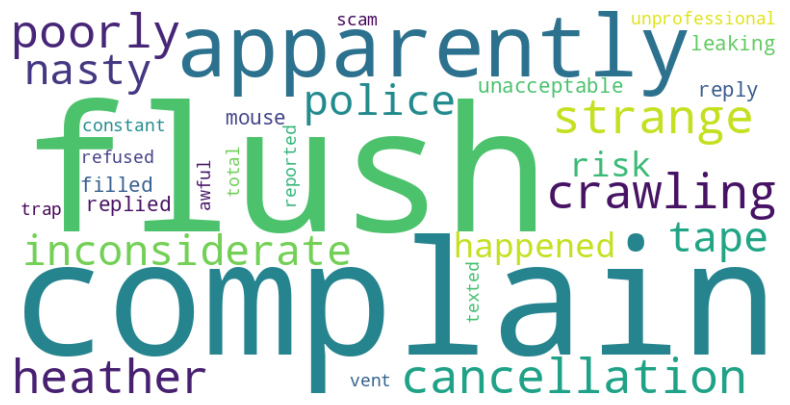

word cloud for sentiment score  2


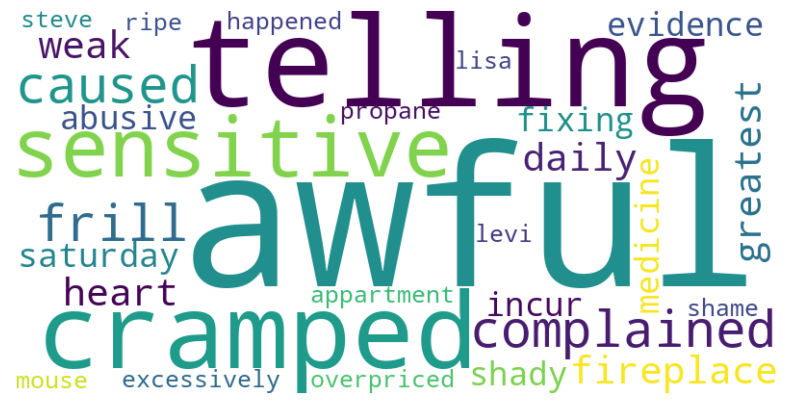

word cloud for sentiment score  3


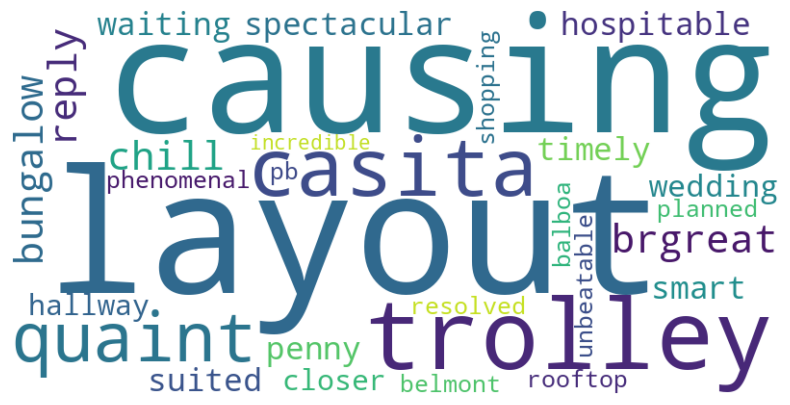

word cloud for sentiment score  4


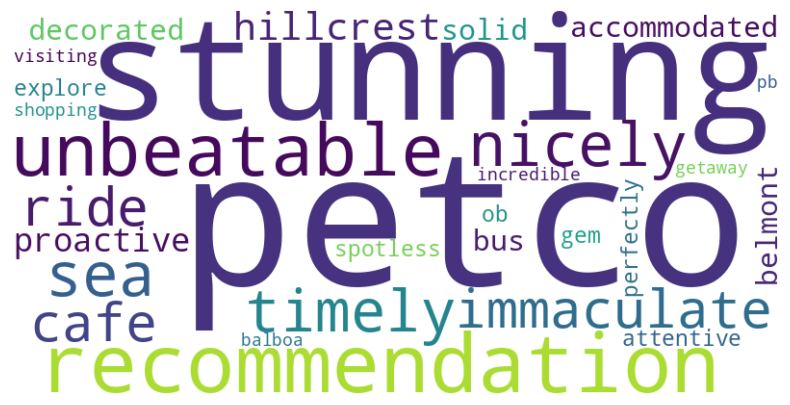

word cloud for sentiment score  5


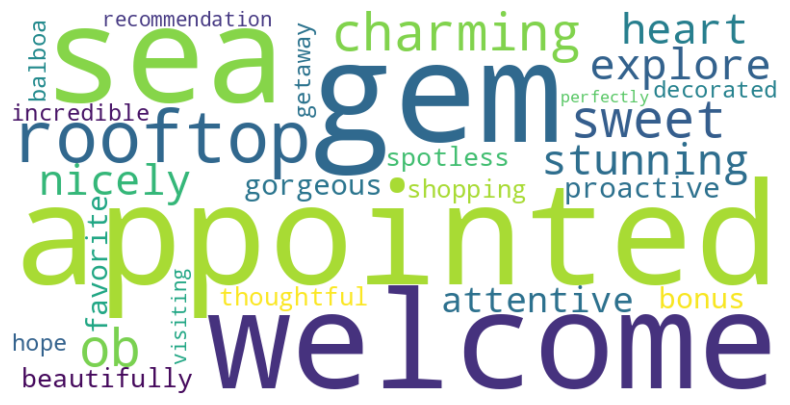

In [44]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'grouped_comments_df' with the top words
sentiment_score = [1,2,3,4,5]
for i in sentiment_score:  # Choose the sentiment score you want to visualize
  text = ' '.join(grouped_comments_df[grouped_comments_df['sentiment_scaled'] ==i ]['dominant_topic'].astype(str).tolist())

  # Create and generate a word cloud image:
  wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

  # Display the generated image:
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  print("word cloud for sentiment score ",i)
  plt.show()


In [45]:
# look at the statistics of the scaled_sentiment
print(san_diego_reviews_cleaned_nonull['sentiment_scaled'].describe())
print(san_diego_listings_cleaned.shape)
# sort the lisiting data by id
san_diego_listings_cleaned = san_diego_listings_cleaned.sort_values(by='id')
# check what it looks like




count    47707.000000
mean         4.690066
std          0.671658
min          1.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: sentiment_scaled, dtype: float64
(10638, 33)


Now that we have the sentiment scores for all the availale ids we will join these back with the other data set to finally run our analysis

In [46]:
merged_df = san_diego_reviews_cleaned_nonull.merge(
    san_diego_listings_cleaned,
    how='left',
    left_on='listing_id',
    right_on='id'
)
merged_df = merged_df.drop_duplicates(subset='listing_id', keep='first')
# check what this looks like
print(merged_df.head())

    listing_id       date                                           comments  \
0            6 2024-10-20  Loved our stay! We were there for a wedding in...   
5        12447 2024-10-25  Great room, exactly what is portrayed in the p...   
9        29967 2024-08-22  Extremely roomy and comfortable home in a grea...   
14       54001 2024-11-02  I had a wonderful time at Marsha's place. It i...   
19       62274 2024-11-30  Isabel and her dog Phinneas are precious!  Thi...   

    sentiment_scaled     id                                             name  \
0                5.0      6  North Park Craftsmen House * Great for Families   
5                5.0  12447                     Cozy Pacific Beach Hideaway!   
9                5.0  29967                 Great home, 10 min walk to Beach   
14               5.0  54001      La Jolla: 2 Bedrooms, 1 Bath, 3Blks 2 Ocean   
19               5.0  62274               charming, colorful, close to beach   

    host_id  host_response_rate  host_

We compare price vs sentiment to see if there is any correlation b/w really positive sentiments and price of the place - do note that the number of 5 point scores was much higher than other scores.

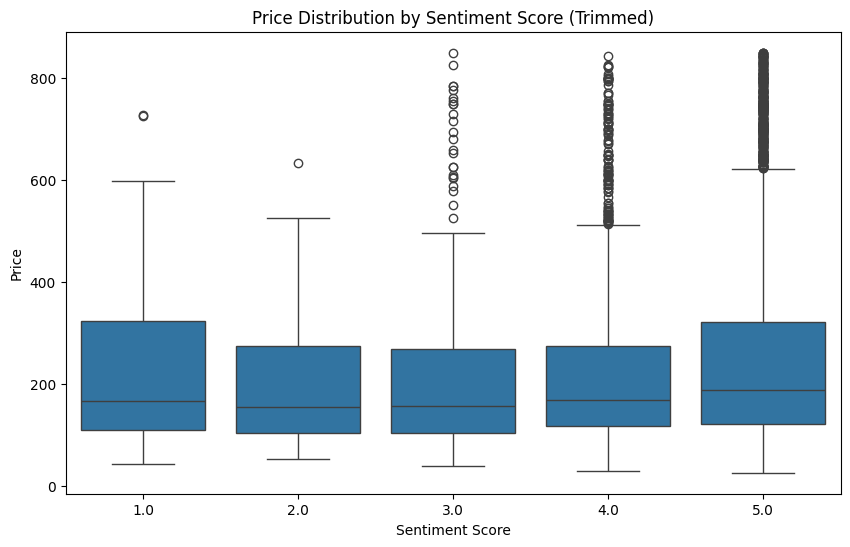

In [47]:
# Trim prices above the 95th percentile
threshold = merged_df['price'].quantile(0.95)
trimmed_df = merged_df[merged_df['price'] <= threshold]

# Plot again using trimmed data
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment_scaled', y='price', data=trimmed_df)
plt.title('Price Distribution by Sentiment Score (Trimmed)')
plt.xlabel('Sentiment Score')
plt.ylabel('Price')
plt.show()



We compare the number of bedrooms vs sentiment

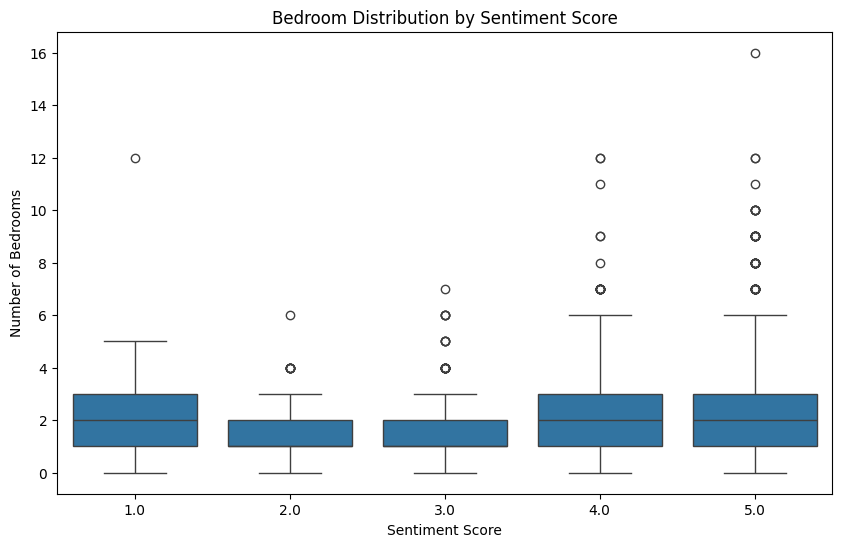

In [48]:


# Plot again using trimmed data
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment_scaled', y='bedrooms', data=merged_df)
plt.title('Bedroom Distribution by Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Bedrooms')
plt.show()

